In [1]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\spaghetti\network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
db = geopandas.read_file("regression_db.geojson")

In [3]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

In [4]:
from pysal.model import spreg

# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

In [5]:
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:     1320.15                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

------------------------------------------------------------

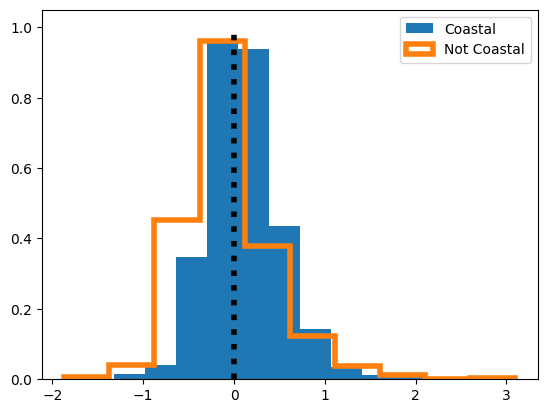

In [6]:
# Create a Boolean (True/False) with whether a
# property is coastal or not
is_coastal = db.coastal.astype(bool)
# Split residuals (m1.u) between coastal and not
coastal = m1.u[is_coastal]
not_coastal = m1.u[~is_coastal]
# Create histogram of the distribution of coastal residuals
plt.hist(coastal, density=True, label="Coastal")
# Create histogram of the distribution of non-coastal residuals
plt.hist(
    not_coastal,
    histtype="step",
    density=True,
    linewidth=4,
    label="Not Coastal",
)
# Add Line on 0
plt.vlines(0, 0, 1, linestyle=":", color="k", linewidth=4)
# Add legend
plt.legend()
# Display
plt.show()

In [7]:
from scipy.stats import ttest_ind

ttest_ind(coastal, not_coastal)

TtestResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]), df=array([6108.]))

C:\Users\flori\AppData\Local\Temp\ipykernel_10996\4009308338.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.boxplot(


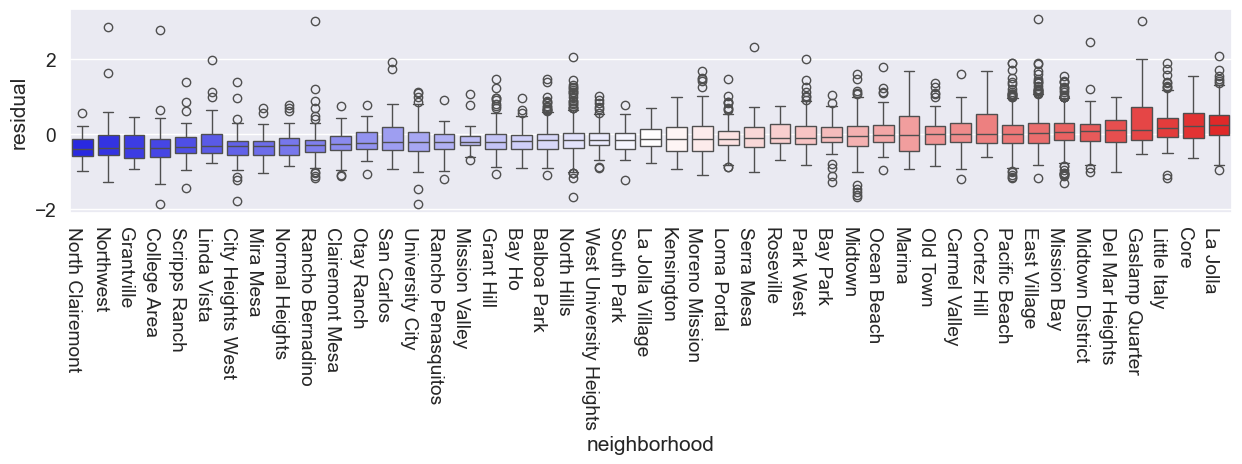

In [8]:
# Create column with residual values from m1
db["residual"] = m1.u
# Obtain the median value of residuals in each neighborhood
medians = (
    db.groupby("neighborhood")
    .residual.median()
    .to_frame("hood_residual")
)

# Increase fontsize
seaborn.set(font_scale=1.25)
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighborhood
# Note the data includes the median values merged on-the-fly
seaborn.boxplot(
    x="neighborhood",
    y="residual",
    ax=ax,
    data=db.merge(
        medians, how="left", left_on="neighborhood", right_index=True
    ).sort_values("hood_residual"),
    palette="bwr",
)
# Rotate the X labels for legibility
f.autofmt_xdate(rotation=-90)
# Display
plt.show()

c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 1849 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


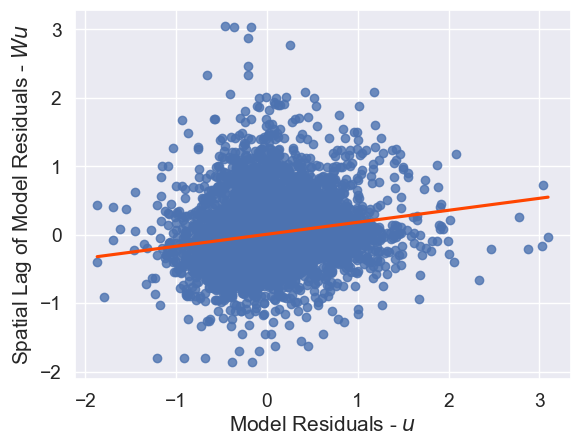

In [9]:
knn = weights.KNN.from_dataframe(db, k=1)
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    x=m1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $W u$");

c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


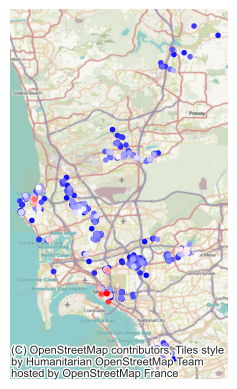

In [10]:
# Re-weight W to 20 nearest neighbors
knn.reweight(k=20, inplace=True)
# Row standardize weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    db.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".")
)
# Add basemap
contextily.add_basemap(ax, crs=db.crs)
# Remove axes
ax.set_axis_off()